In [25]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from potentials import BananaShape
from zv_cv import Eval_ZVCV
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [60]:
N_burn = 1*10**4 # Burn in period
N_train = 1*10**5 # Number of samples on which we optimize
#N_test = 2*10**3 # Number of samples
step = 0.1 # Step size
#put 0.5 for MALA
#step = 0.2
n_traj = 24 # Number of independent MCMC trajectories for test
f_type = "sum"
bn = 300
W_test = construct_ESVM_kernel(N_train,bn)

Choose density parameters

In [61]:
d = 8
B = 0.1
M = 10
Cur_pot = BananaShape(B,M,d)

### Generate data

In [62]:
sampler = {"sampler":"ULA","burn_type":"full","main_type":"full"} # Sampling method

if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12


In [63]:
print(traj.shape)
print(traj_grad.shape)
traj_grad = (-1)*traj_grad

(24, 100000, 8)
(24, 100000, 8)


In [64]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV, [(traj[i,:,:],traj_grad[i,:,:],f_type,None,W_test) for i in range (n_traj)])
trav.close()

In [65]:
res_arr = np.asarray(res)
print(res_arr.shape)

(24, 2, 5)


### Save results

In [66]:
np.save("banana/ula_linear_15_04.npy",res_arr)
print("Average vr rates:")
print("ZV-1:",np.mean(res_arr[:,1,0]/res_arr[:,1,1]))
print("CV-1:",np.mean(res_arr[:,1,0]/res_arr[:,1,3]))
print("ZV-2:",np.mean(res_arr[:,1,0]/res_arr[:,1,2]))
print("ZV-2:",np.mean(res_arr[:,1,0]/res_arr[:,1,4]))

Average vr rates:
ZV-1: 1.3909470535237853
CV-1: 3.266230771556403
ZV-2: 2.42002307522985
ZV-2: 20.234962809519477


### Comparison plots

In [67]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith ZV-1', 'ULA \nwith CV-1']

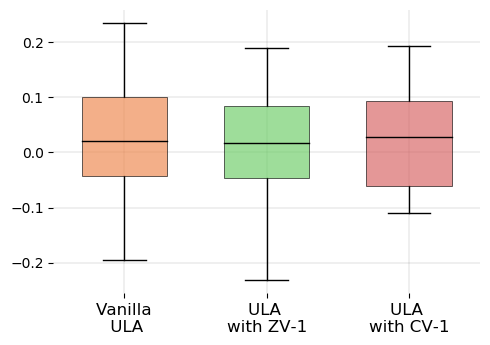

In [68]:
data = [res_arr[:,0,0],res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels)

In [69]:
title = ""
labels = ['MALA \nwith ZV-1', 'MALA \nwith CV-1']

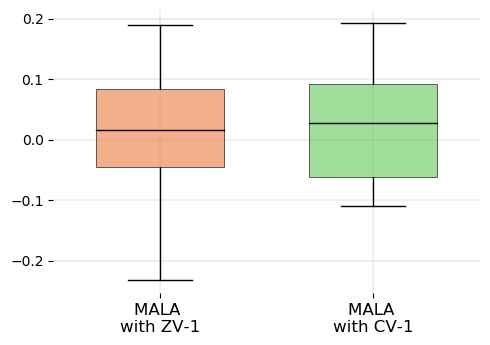

In [70]:
data = [res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels)

In [71]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith ZV-2', 'ULA \nwith CV-2']

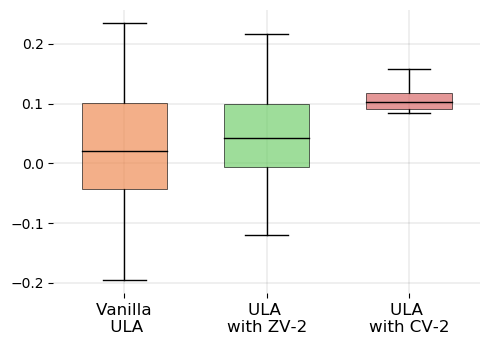

In [72]:
data = [res_arr[:,0,0],res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)

In [73]:
title = ""
labels = ['ULA \nwith ZV-2', 'ULA \nwith CV-2']

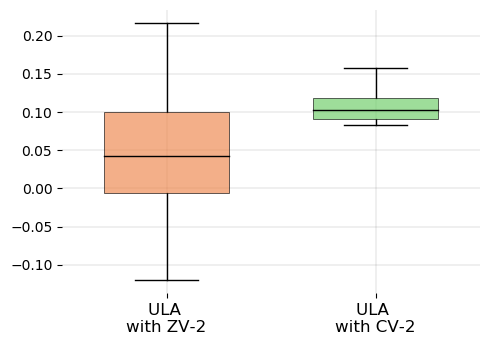

In [74]:
data = [res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)